In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn import metrics
import sys
import PROST
PROST.__version__

' 1.1.2 '

In [2]:
#%% init
SEED = 818
PROST.setup_seed(SEED)

# Set directory (If you want to use additional data, please change the file path)
rootdir = 'datasets/Slide-seq/'

input_dir = os.path.join(rootdir)
output_dir = os.path.join(rootdir, 'results/')
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

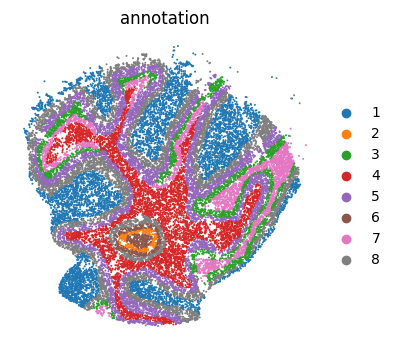

In [3]:
# Read data
adata = sc.read(input_dir+"used_data.h5")

# Plot annotation
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.embedding(adata, basis="spatial", color="annotation",size = 8, show=False, title='annotation')
plt.axis('off')
plt.savefig(output_dir+"annotation.png", dpi=600, bbox_inches='tight')



Filtering genes ...


Trying to set attribute `.var` of view, copying.



Normalization to each gene:


100%|████████████████████████████████████████████████████████████████████████████| 2193/2193 [00:00<00:00, 3513.47it/s]



Gaussian filtering for each gene:


100%|██████████████████████████████████████████████████████████████████████████████| 2193/2193 [06:08<00:00,  5.96it/s]



Binary segmentation for each gene:


100%|█████████████████████████████████████████████████████████████████████████████| 2193/2193 [00:07<00:00, 305.77it/s]



Spliting subregions for each gene:


100%|██████████████████████████████████████████████████████████████████████████████| 2193/2193 [00:24<00:00, 88.86it/s]



Computing PROST Index for each gene:


100%|██████████████████████████████████████████████████████████████████████████████| 2193/2193 [06:15<00:00,  5.83it/s]



PROST Index calculation completed !!

Drawing pictures:


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.73s/it]



Drawing completed !!


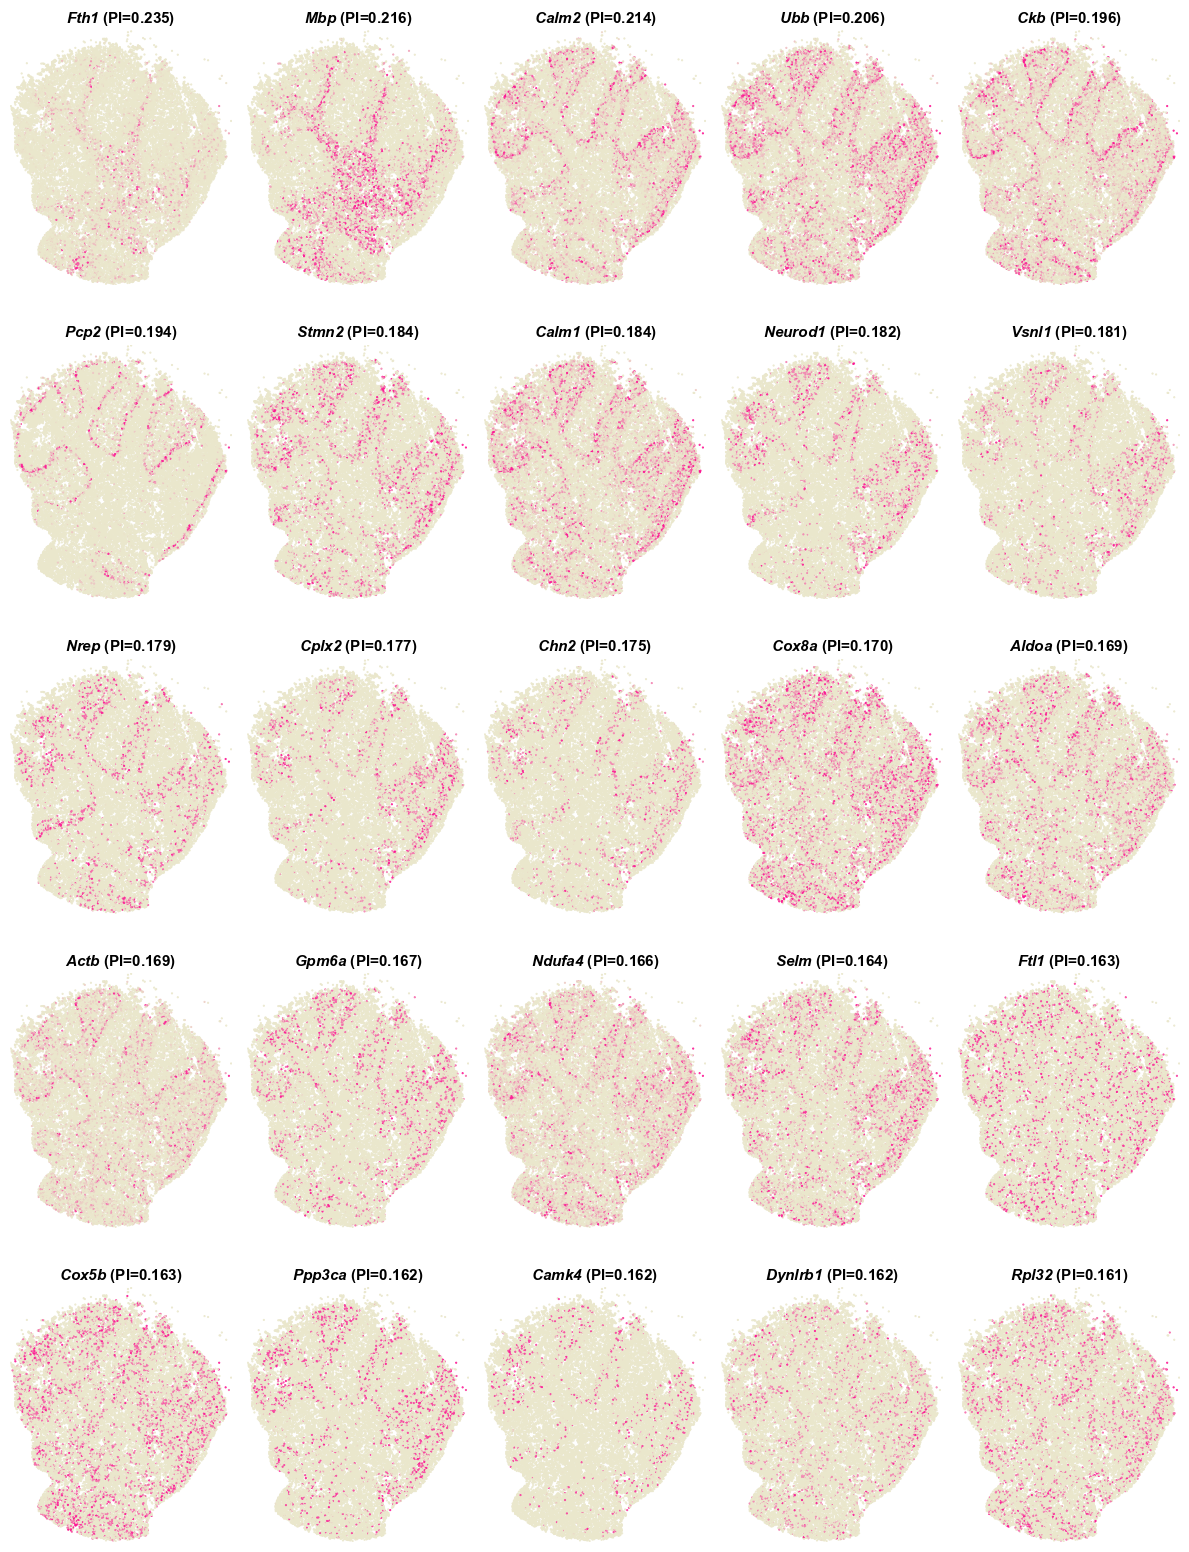

In [4]:
#%% PI 
# Calculate PI
adata = PROST.prepare_for_PI(adata, percentage = 0.01, platform="Slide-seq")
adata = PROST.cal_PI(adata, platform="Slide-seq")

# Save PI
adata.write_h5ad(output_dir+"/PI_result.h5")

# Draw SVGs detected by PI
PROST.plot_gene(adata, platform="Slide-seq", sorted_by='PI', size = 0.3, top_n = 25, ncols_each_sheet = 5, nrows_each_sheet = 5,save_path = output_dir)


In [5]:
#%% Clustering
# 1.Expression data preprocessing
adata = sc.read(input_dir+ "/used_data.h5")
sc.pp.normalize_total(adata)    
sc.pp.log1p(adata)

# 2.Run PROST
PROST.run_PNN(adata, 
              platform="slide-seq", 
              min_distance = 80,
              init="mclust",
              n_clusters = 8,                   
              tol = 5e-3,
              SEED=SEED,
              max_epochs = 25)

# 3.Calcluate ARI
ARI = metrics.adjusted_rand_score(adata.obs["annotation"], adata.obs["clustering"])
print("pp_clustering_ARI =", ARI)

#4 Save result
adata.obs["clustering"].to_csv(output_dir + "/clustering.csv", header = False)
np.savetxt(output_dir + "/embedding.txt", adata.obsm["PROST"])
adata.write_h5ad(output_dir + "/PNN_result.h5")


Calculating adjacency matrix ...

Running PCA ...
Laplacian Smoothing ...

Initializing cluster centers with mclust, n_clusters known


Epoch: : 27it [19:21, 43.02s/it, loss=0.1746949]                                                                       


Clustering completed !!
pp_clustering_ARI = 0.3332276319944897


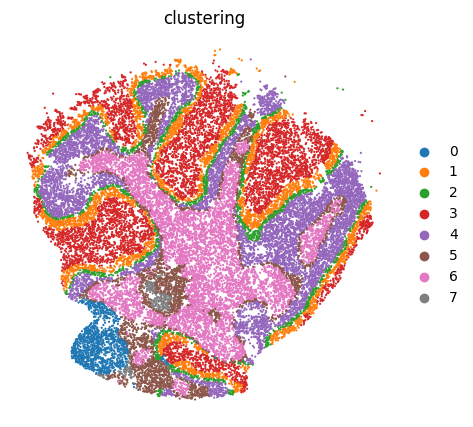

In [6]:
#%% PLot cluster result
adata = sc.read(output_dir + "/PNN_result.h5")
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="clustering", size = 10, show=False, title='clustering')
plt.axis('off')
plt.savefig(output_dir+"/clustering.png", dpi=600, bbox_inches='tight')
